In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# import models
from models import Discriminator, INN
import data
import torchvision
import pandas as pd
from torchvision import datasets, transforms
# import cuml
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm.notebook import tqdm
from utils import config

c = config.Config()
c.load('./config/default.toml')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def make_cond(labels):
    cond_tensor = torch.zeros(labels.size(0), c.ncl).cuda()
    if c.conditional:
        cond_tensor.scatter_(1, labels.view(-1, 1), 1.)
    else:
        cond_tensor[:, 0] = 1
    return cond_tensor

fill = torch.zeros((10, 10, 32, 32), device=device)
for i in range(10):
    fill[i, i, :, :] = 1

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('~/Data', split='digits', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        transforms.Lambda(lambda x: x.permute(0, 2, 1)),
                    ])),
    batch_size=512, shuffle=False, pin_memory=True, num_workers=4,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('~/Data', split='digits', train=False, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        transforms.Lambda(lambda x: x.permute(0, 2, 1)),
                    ])),
    batch_size=512, shuffle=True, pin_memory=True, num_workers=4,
    drop_last=True
)
letter_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('~/Data', split='letters', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        transforms.Lambda(lambda x: x.permute(0, 2, 1)),
                    ])),
    batch_size=512, shuffle=True, pin_memory=True, num_workers=4,
    drop_last=True
)
fashion_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('~/Data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        transforms.Lambda(lambda x: x.permute(0, 2, 1)),
                    ])),
    batch_size=512, shuffle=True, pin_memory=True, num_workers=4,
    drop_last=True
)
kmnist_loader = torch.utils.data.DataLoader(
    datasets.KMNIST('~/Data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.Pad(2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        transforms.Lambda(lambda x: x.permute(0, 2, 1)),
                        # transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                    ])),
    batch_size=512, shuffle=True, pin_memory=True, num_workers=4,
    drop_last=True
)


In [3]:
inn = INN().to(device)
inn.load_state_dict(dict(filter(lambda x: 'tmp' not in x[0], torch.load('runs/May13_19-39-26_GLaDOS/checkpoints/generator_in.pt').items())))

<All keys matched successfully>

In [3]:
# Initialize sampling distribution
latent = torch.empty(0, 32 * 32)
classes = torch.empty(0).long()
with torch.no_grad():
    for x, y in tqdm(data.train_loader):
        x = x.to(device)
        y = y.to(device)
        cond = [
            fill[:, :, :16, :16][y],
            fill[:, :, :8, :8][y],
            make_cond(y)
        ]
        output = inn(x, cond)
        latent = torch.cat([latent, output.data.cpu()])
        classes = torch.cat([classes, y.data.cpu()])

mean = latent.mean(dim=0).to(device)
cov = torch.tensor(np.cov(latent.cpu().numpy().T), device=device,
                   dtype=torch.float)

torch.save(latent, "runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
torch.save(classes, "runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")



# latent_dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
# latent_dist = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(1024, dtype=torch.float, device=device), torch.eye(1024, dtype=torch.float, device=device))

ValueError: 'c' argument has 239616 elements, which is not acceptable for use with 'x' with size 23973, 'y' with size 23973.

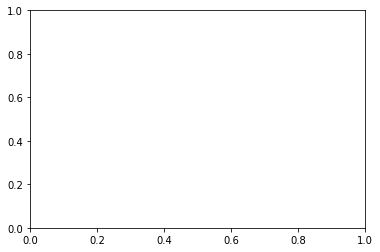

In [40]:
_, _, v = torch.svd(latent[classes == 0])
latent_pca = (latent[classes == 0]) @ v[:, :2]

fig, ax = plt.subplots()
ax.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.4,
           c=classes, cmap='tab10', vmin=0, vmax=9)
ax.set_aspect('equal')

In [4]:
for i in range(10):
    latent_lt = torch.empty(0, 32 * 32)
    classes_lt = torch.empty(0).long()
    with torch.no_grad():
        for x, y in tqdm(letter_loader):
            x = x.to(device)
            y_ = i * torch.ones_like(y, device=device)
        #         y_ = torch.randint(10, y.shape, device=device)
            y = y.to(device)
            cond = [
                fill[:, :, :16, :16][y_],
                fill[:, :, :8, :8][y_],
                make_cond(y_)
            ]
            output = inn(x, cond)
            latent_lt = torch.cat([latent_lt, output.data.cpu()])
            classes_lt = torch.cat([classes_lt, y.data.cpu()])

    torch.save(latent_lt, f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_{i}.pt")
    torch.save(classes_lt, f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_{i}.pt")

In [28]:
for i in range(10):
    latent_fs = torch.empty(0, 32 * 32)
    classes_fs = torch.empty(0).long()
    with torch.no_grad():
        for x, y in tqdm(fashion_loader):
            x = x.to(device)
            y_ = i * torch.ones_like(y, device=device)
        #         y_ = torch.randint(10, y.shape, device=device)
            y = y.to(device)
            cond = [
                fill[:, :, :16, :16][y_],
                fill[:, :, :8, :8][y_],
                make_cond(y_)
            ]
            output = inn(x, cond)
            latent_fs = torch.cat([latent_fs, output.data.cpu()])
            classes_fs = torch.cat([classes_fs, y.data.cpu()])

    torch.save(latent_fs, f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_{i}.pt")
    torch.save(classes_fs, f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_{i}.pt")

In [29]:
for i in range(10):
    latent_km = torch.empty(0, 32 * 32)
    classes_km = torch.empty(0).long()
    with torch.no_grad():
        for x, y in tqdm(kmnist_loader):
            x = x.to(device)
            y_ = i * torch.ones_like(y, device=device)
        #         y_ = torch.randint(10, y.shape, device=device)
            y = y.to(device)
            cond = [
                fill[:, :, :16, :16][y_],
                fill[:, :, :8, :8][y_],
                make_cond(y_)
            ]
            output = inn(x, cond)
            latent_km = torch.cat([latent_km, output.data.cpu()])
            classes_km = torch.cat([classes_km, y.data.cpu()])

    torch.save(latent_km, f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_{i}.pt")
    torch.save(classes_km, f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_{i}.pt")

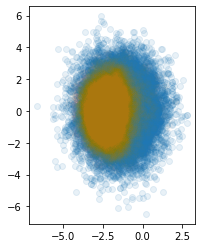

In [6]:
mean = torch.load("mean.pt")
cov = torch.load("cov.pt")

def b(log_n):
    if type(log_n) is not torch.Tensor:
        log_n = torch.tensor(log_n, device=device, dtype=torch.float)

    return torch.sqrt(2 * log_n) - (torch.log(log_n) + torch.log(4 * torch.tensor(np.pi)))/(2 * torch.sqrt(2 * log_n))


def a(log_n):
    if type(log_n) is not torch.Tensor:
        log_n = torch.tensor(log_n, device=device, dtype=torch.float)

    return torch.sqrt(2 * log_n)

w, v = torch.eig(cov, eigenvectors=True)

s = 1.5
gumbel = torch.distributions.gumbel.Gumbel(32+b((s*32 - 32)**2)*0.7, 1/a((s*32
                                                                          - 32)**2)*0.7)
typical = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
std_normal = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.zeros(32*32, device=device),
    torch.eye(32*32, device=device)
)

zs = torch.empty(0, 32 * 32)

for i in range(100):
    # OUT SAMPLE
    z = std_normal.sample((200,))
    z /= torch.norm(z, dim=1)[:, None]

    # sample mahalanobis radius and convert to euclidean
    r = gumbel.sample((200,)).to(device)
    r = r[:, None, None] * (torch.sqrt(torch.diag(w[:, 0])) @ v.T)[None, :, :]

    # combine direction and radius
    z = z[:, None, :] @ r
    z = z.reshape(-1, 32*32)
    z += mean
    zs = torch.cat([zs, z.to("cpu")])

latent = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
classes = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
    
_, _, v = torch.svd(latent[classes == 0])
latent_pca = (latent[classes == 0]) @ v[:, :2]
z_ = zs @ v[:, :2]

fig, ax = plt.subplots()
ax.scatter(z_[:, 0], z_[:, 1], alpha=0.1)
ax.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.01)

ax.set_aspect('equal')
fig.show()

In [ ]:
latent = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")[:20000]
classes = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")[:20000]

d_matrix = np.zeros((10, 26))
    
fig, ax = plt.subplots(figsize=(22, 22))

for i in tqdm(range(10)):

    latent_lt = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_{i}.pt")[:50000]
    classes_lt = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_{i}.pt")[:50000]
    
    lda = LinearDiscriminantAnalysis(n_components=2)
    
    all_data = torch.cat([latent[classes == i], latent_lt], dim=0)
    all_targets = torch.cat([i * torch.ones((latent[classes == i].shape[0],), dtype=torch.long), 10 + classes_lt])
    lda.fit(all_data, all_targets)
    
    latent_pca = lda.transform(latent[classes == i][:1000])[:, :2]
    latent_lt_pca = lda.transform(latent_lt)[:, :2]
    print(f"num: {latent_pca.shape}")
    print(f"let: {latent_lt_pca.shape}")
    
    for j in range(26):
        d_matrix[i, j] = np.linalg.norm(latent_pca - latent_lt_pca[classes_lt == j+1][:1000], axis=1).mean()
        


ax.matshow(d_matrix)
fig.show()

num: (1000, 2)
let: (50000, 2)
num: (1000, 2)
let: (50000, 2)
num: (1000, 2)
let: (50000, 2)
num: (1000, 2)
let: (50000, 2)
num: (1000, 2)
let: (50000, 2)
num: (1000, 2)
let: (50000, 2)
num: (1000, 2)
let: (50000, 2)
num: (1000, 2)
let: (50000, 2)
num: (1000, 2)
let: (50000, 2)


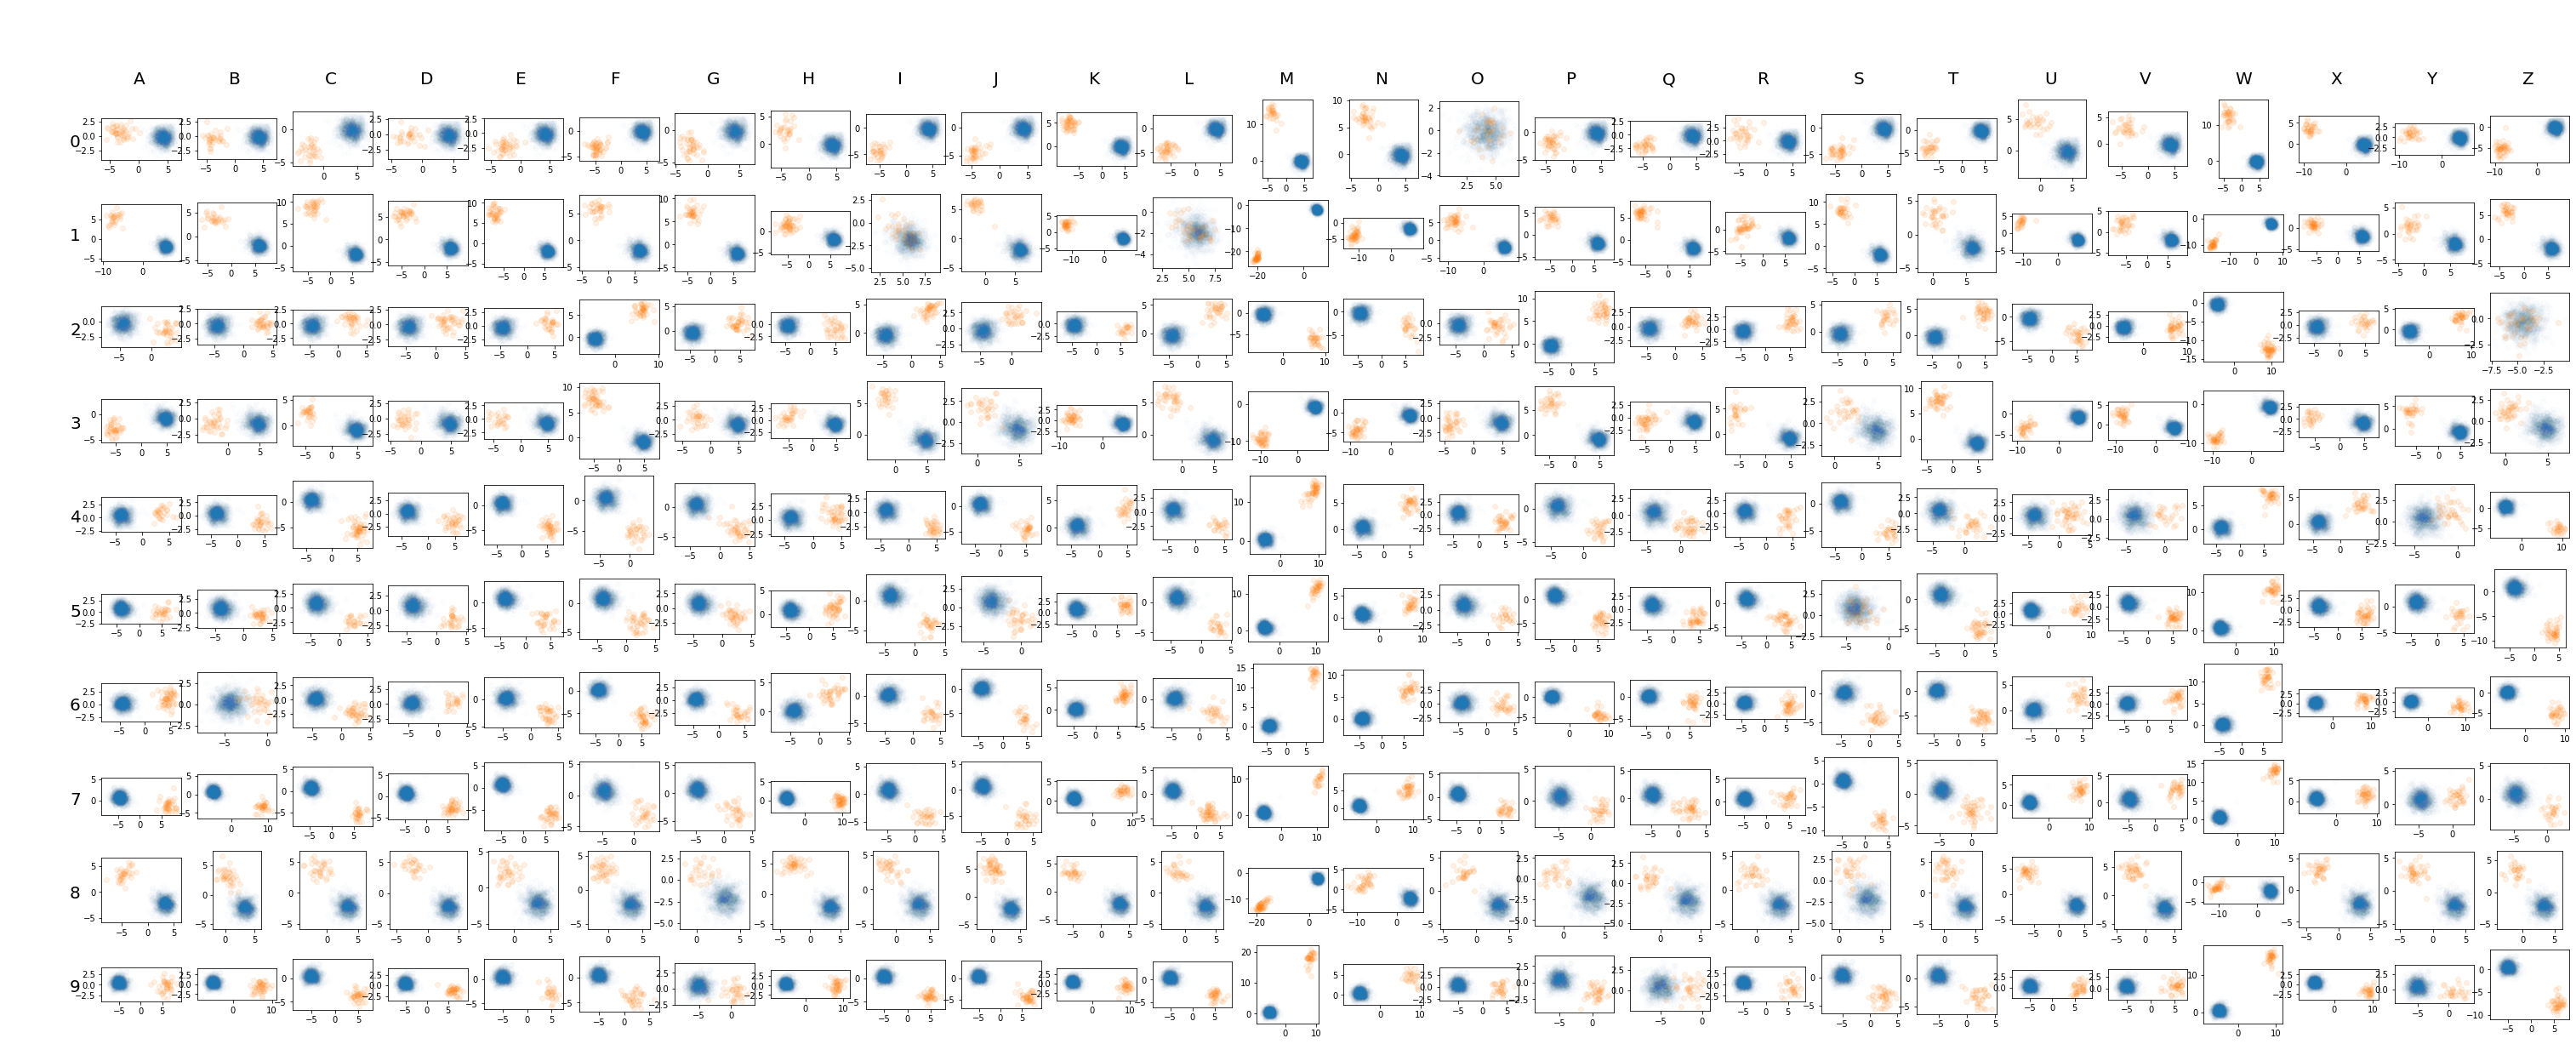

In [12]:
latent = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")[:10000]
classes = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")[:10000]
    
fig, axes = plt.subplots(11, 27, figsize=(54, 22))

for i in tqdm(range(10)):

    latent_lt = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_{i}.pt")[:1000]
    classes_lt = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_{i}.pt")[:1000]
    
    lda = LinearDiscriminantAnalysis(n_components=2)
    
    all_data = torch.cat([latent[classes == i], latent_lt], dim=0)
    all_targets = torch.cat([i * torch.ones((latent[classes == i].shape[0],), dtype=torch.long), 10 + classes_lt])
    lda.fit(all_data, all_targets)
    
    latent_pca = lda.transform(latent[classes == i])
    latent_lt_pca = lda.transform(latent_lt)

    
    for j in range(26):

        ax = axes[i+1, j+1]

        ax.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.01)
        ax.scatter(latent_lt_pca[classes_lt == (j+1)][:, 0], latent_lt_pca[:, 1][classes_lt == (j+1)], alpha=0.1)

        ax.set_aspect('equal')

axes[0, 0].set_axis_off()

ltrs = [chr(ord("A") + i) for i in range(26)]

for i in range(26):
    axes[0, i+1].annotate(ltrs[i], (0.4, 0), fontsize=20)
    axes[0, i+1].set_axis_off()
    
for i in range(10):
    axes[i+1, 0].annotate(f"{i}", (0.8, 0.4), fontsize=20)
    axes[i+1, 0].set_axis_off()

fig.show()

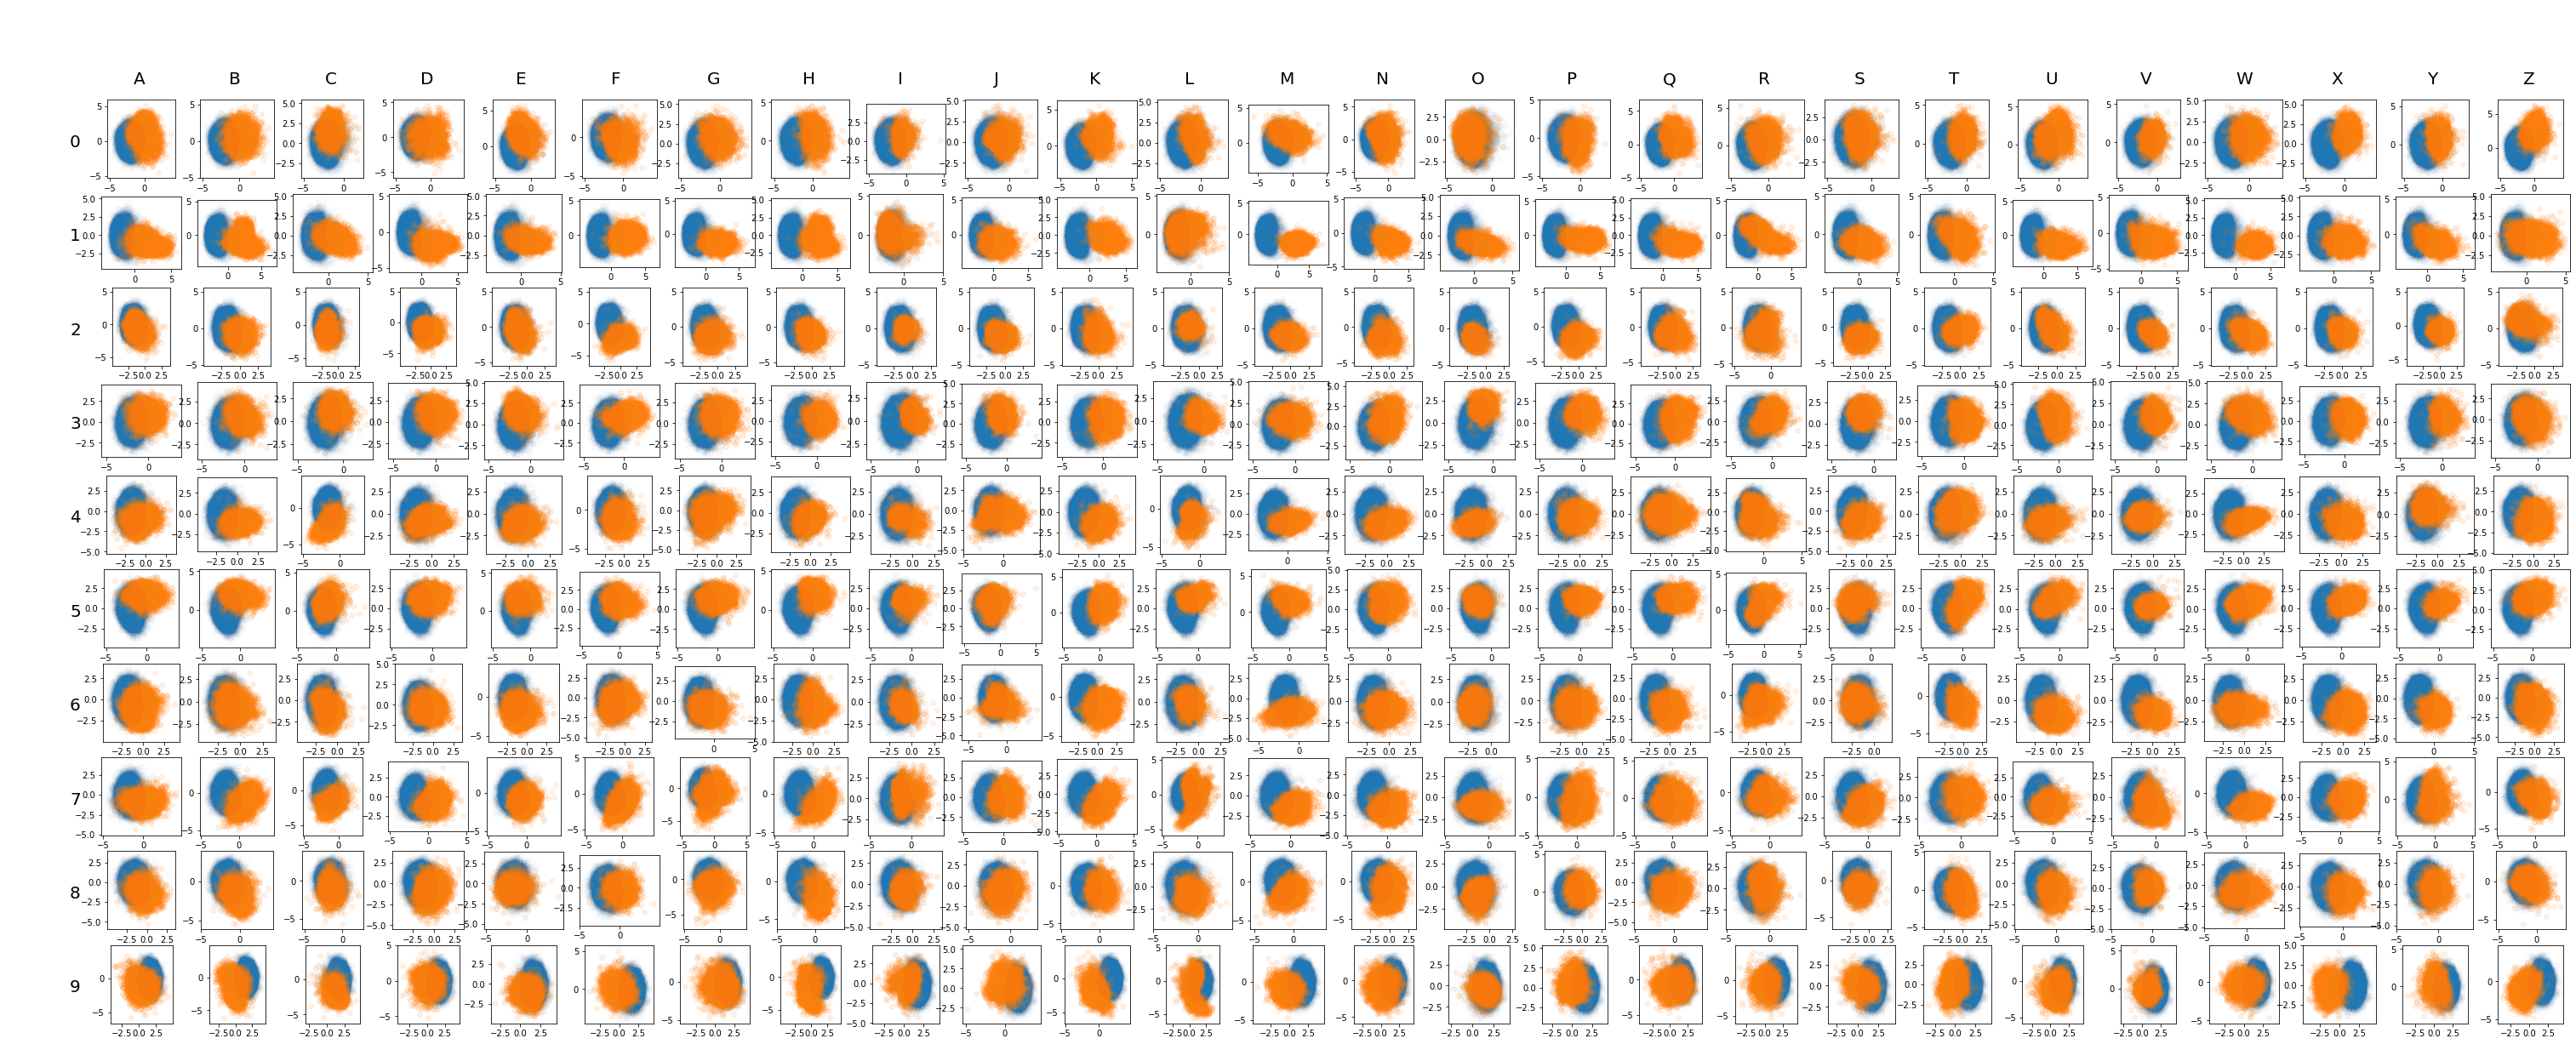

In [30]:
latent = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
classes = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
    
fig, axes = plt.subplots(11, 27, figsize=(54, 22))

for i in range(10):

    _, _, v = torch.svd(latent[classes == i])
    latent_pca = (latent[classes == i]) @ v[:, :2]
    latent_lt = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_{i}.pt")
    classes_lt = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_{i}.pt")
    latent_lt_pca = latent_lt @ v[:, :2]
    
    for j in range(26):

        ax = axes[i+1, j+1]

        ax.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.01)
        ax.scatter(latent_lt_pca[classes_lt == (j+1)][:, 0], latent_lt_pca[:, 1][classes_lt == (j+1)], alpha=0.1)

        ax.set_aspect('equal')

axes[0, 0].set_axis_off()

ltrs = [chr(ord("A") + i) for i in range(26)]

for i in range(26):
    axes[0, i+1].annotate(ltrs[i], (0.4, 0), fontsize=20)
    axes[0, i+1].set_axis_off()
    
for i in range(10):
    axes[i+1, 0].annotate(f"{i}", (0.8, 0.4), fontsize=20)
    axes[i+1, 0].set_axis_off()

fig.show()

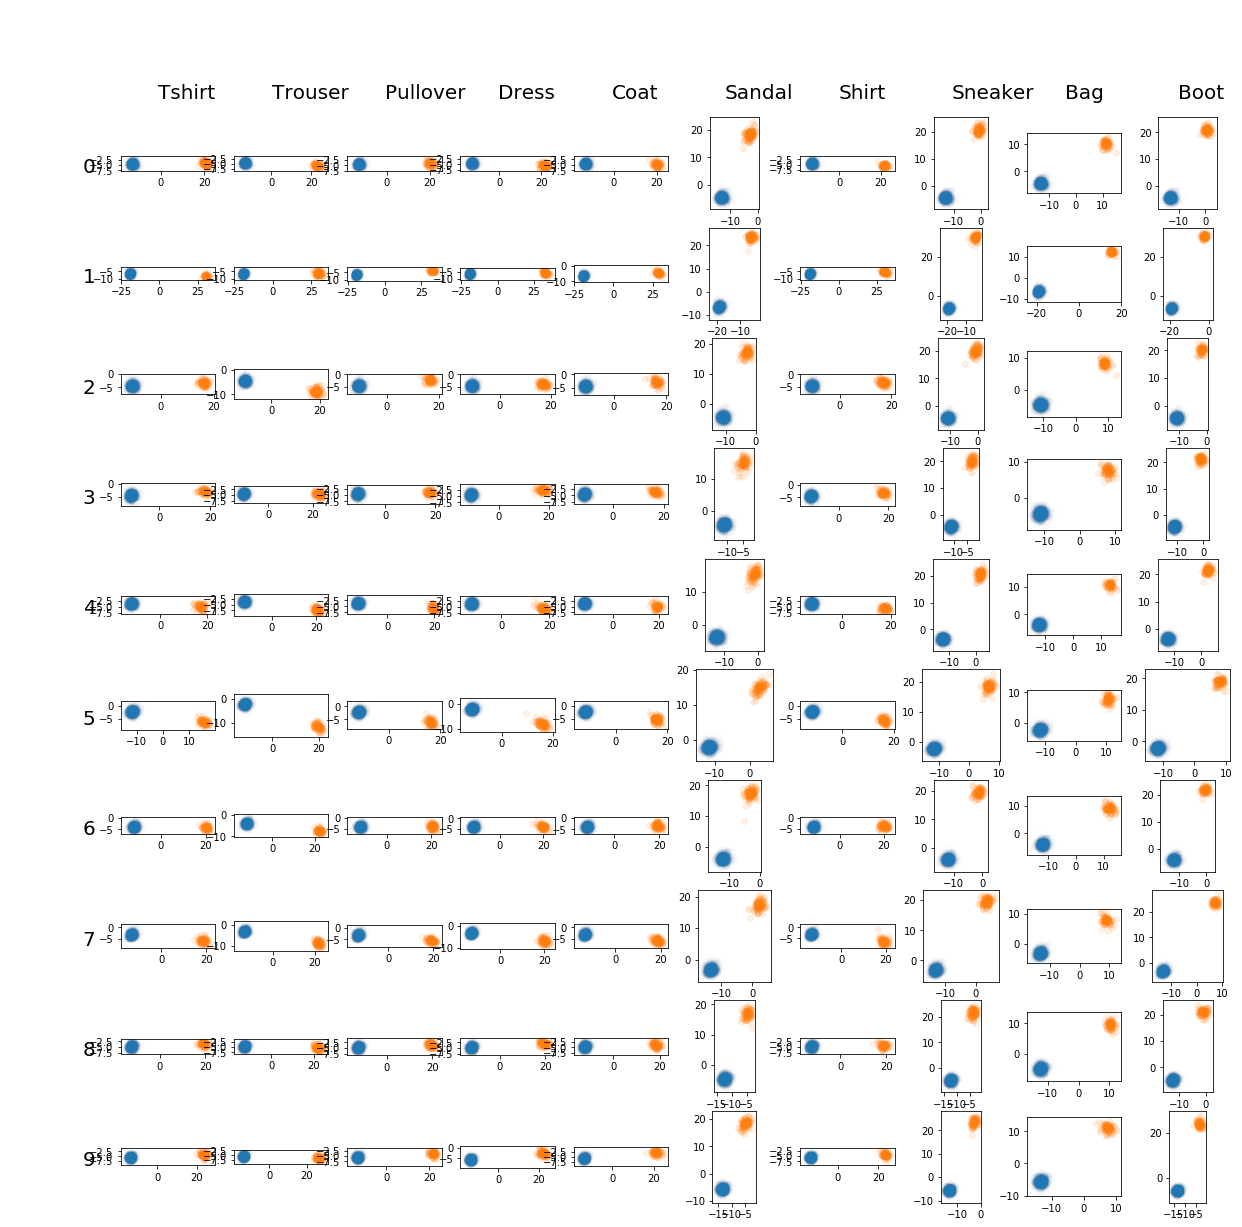

In [14]:
latent = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")[:10000]
classes = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")[:10000]
    
fig, axes = plt.subplots(11, 11, figsize=(22, 22))

for i in tqdm(range(10)):

    latent_fs = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_{i}.pt")[:1000]
    classes_fs = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_{i}.pt")[:1000]
    
    lda = LinearDiscriminantAnalysis(n_components=2)
    
    all_data = torch.cat([latent[classes == i], latent_fs], dim=0)
    all_targets = torch.cat([i * torch.ones((latent[classes == i].shape[0],), dtype=torch.long), 10 + classes_fs])
    lda.fit(all_data, all_targets)
    
    latent_pca = lda.transform(latent[classes == i])
    latent_fs_pca = lda.transform(latent_fs)
    
    for j in range(10):

        ax = axes[i+1, j+1]

        ax.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.01)
        ax.scatter(latent_fs_pca[classes_fs == j][:, 0], latent_fs_pca[:, 1][classes_fs == j], alpha=0.1)

        ax.set_aspect('equal')

axes[0, 0].set_axis_off()

ltrs = ["Tshirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]

for i in range(10):
    axes[0, i+1].annotate(ltrs[i], (0.4, 0), fontsize=20)
    axes[0, i+1].set_axis_off()
    
for i in range(10):
    axes[i+1, 0].annotate(f"{i}", (0.8, 0.4), fontsize=20)
    axes[i+1, 0].set_axis_off()

fig.show()

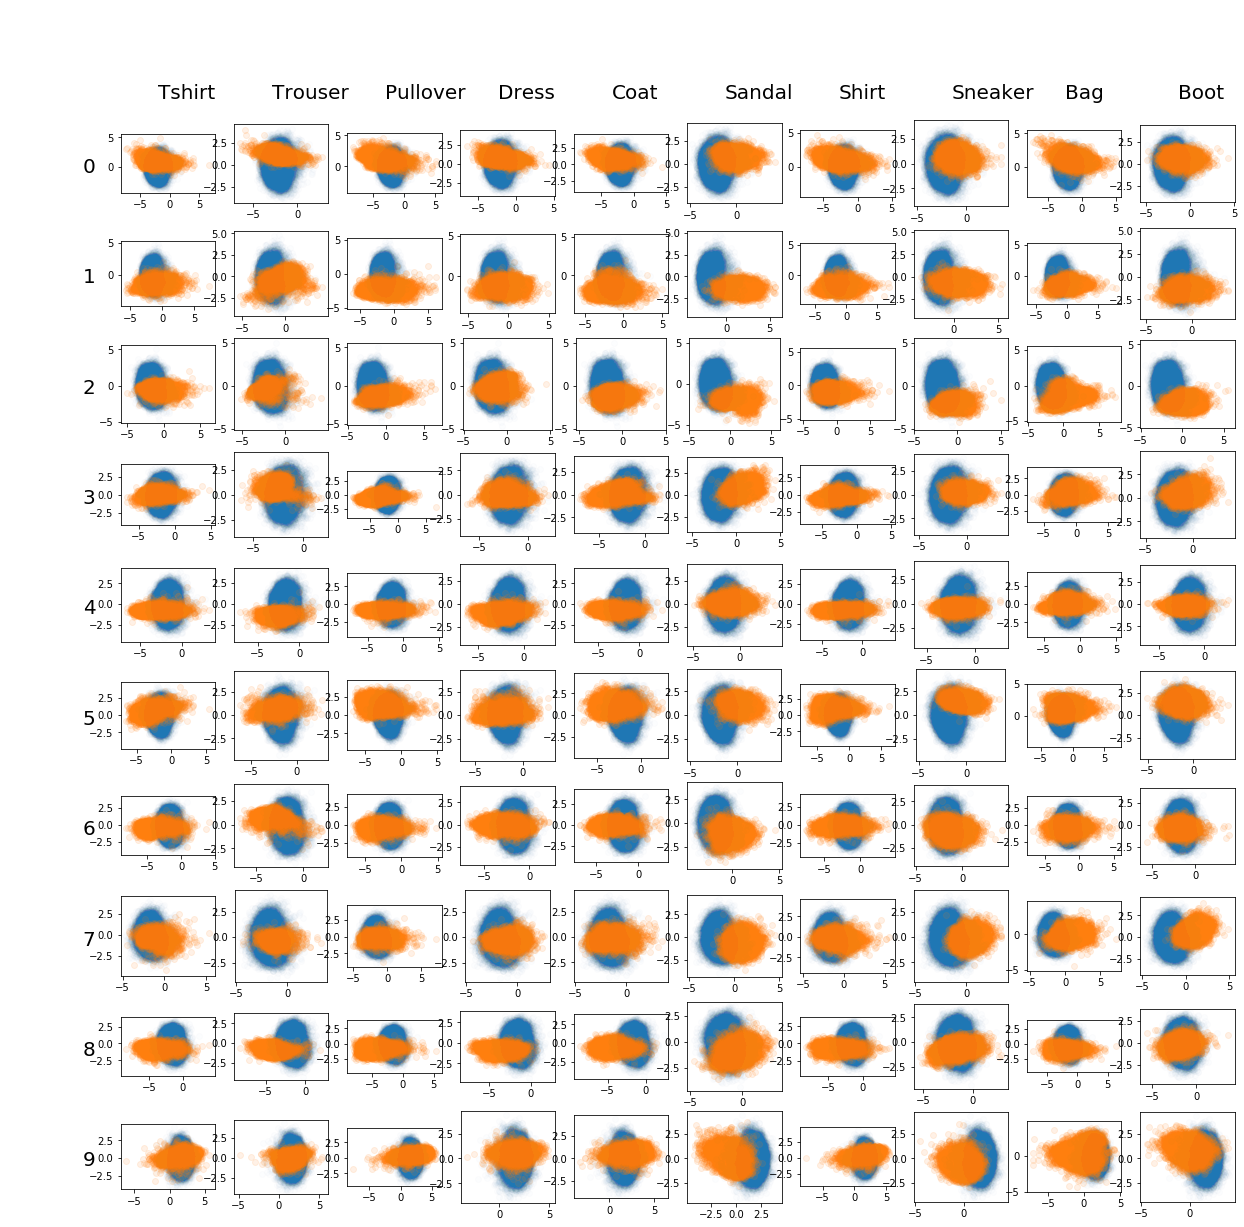

In [3]:
latent = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
classes = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
    
fig, axes = plt.subplots(11, 11, figsize=(22, 22))

for i in range(10):

    _, _, v = torch.svd(latent[classes == i])
    latent_pca = (latent[classes == i]) @ v[:, :2]
    latent_fs = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_{i}.pt")
    classes_fs = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_{i}.pt")
    latent_fs_pca = latent_fs @ v[:, :2]
    
    for j in range(10):

        ax = axes[i+1, j+1]

        ax.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.01)
        ax.scatter(latent_fs_pca[classes_fs == j][:, 0], latent_fs_pca[:, 1][classes_fs == j], alpha=0.1)

        ax.set_aspect('equal')

axes[0, 0].set_axis_off()

ltrs = ["Tshirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Boot"]

for i in range(10):
    axes[0, i+1].annotate(ltrs[i], (0.4, 0), fontsize=20)
    axes[0, i+1].set_axis_off()
    
for i in range(10):
    axes[i+1, 0].annotate(f"{i}", (0.8, 0.4), fontsize=20)
    axes[i+1, 0].set_axis_off()

fig.show()

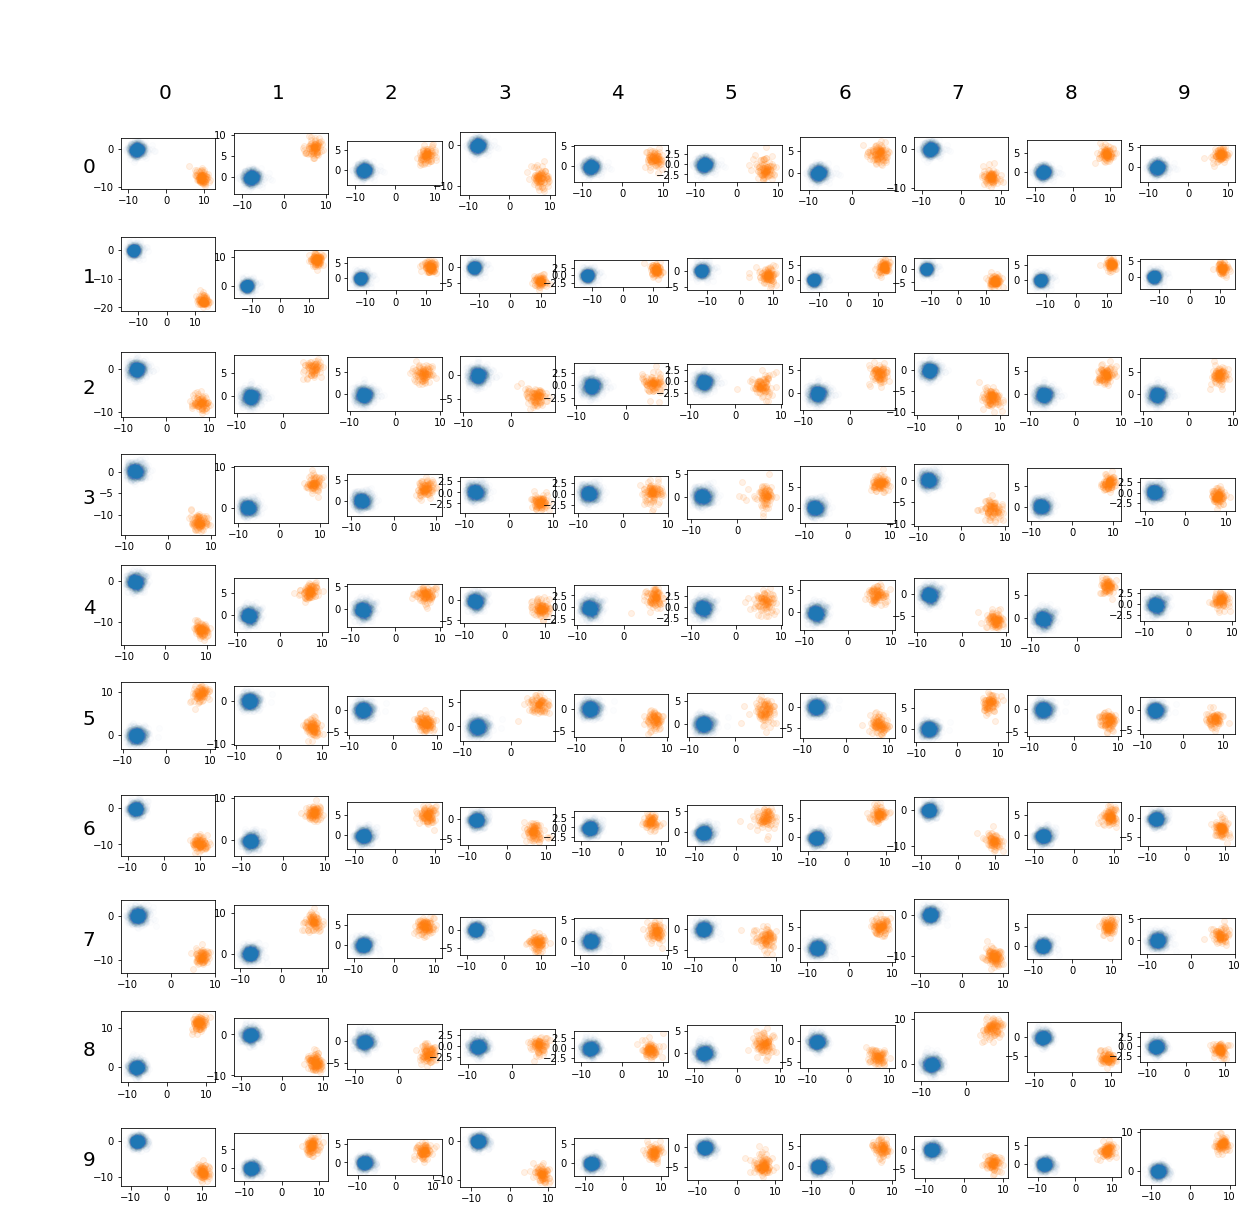

In [13]:
latent = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")[:10000]
classes = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")[:10000]
    
fig, axes = plt.subplots(11, 11, figsize=(22, 22))

for i in tqdm(range(10)):

    latent_km = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_{i}.pt")[:1000]
    classes_km = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_{i}.pt")[:1000]
    
    lda = LinearDiscriminantAnalysis(n_components=2)
    
    all_data = torch.cat([latent[classes == i], latent_km], dim=0)
    all_targets = torch.cat([i * torch.ones((latent[classes == i].shape[0],), dtype=torch.long), 10 + classes_km])
    lda.fit(all_data, all_targets)
    
    latent_pca = lda.transform(latent[classes == i])
    latent_km_pca = lda.transform(latent_km)
    
    for j in range(10):

        ax = axes[i+1, j+1]

        ax.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.01)
        ax.scatter(latent_km_pca[classes_km == j][:, 0], latent_km_pca[:, 1][classes_km == j], alpha=0.1)

        ax.set_aspect('equal')

axes[0, 0].set_axis_off()

for i in range(10):
    axes[0, i+1].annotate(f"{i}", (0.4, 0), fontsize=20)
    axes[0, i+1].set_axis_off()
    
for i in range(10):
    axes[i+1, 0].annotate(f"{i}", (0.8, 0.4), fontsize=20)
    axes[i+1, 0].set_axis_off()

fig.show()

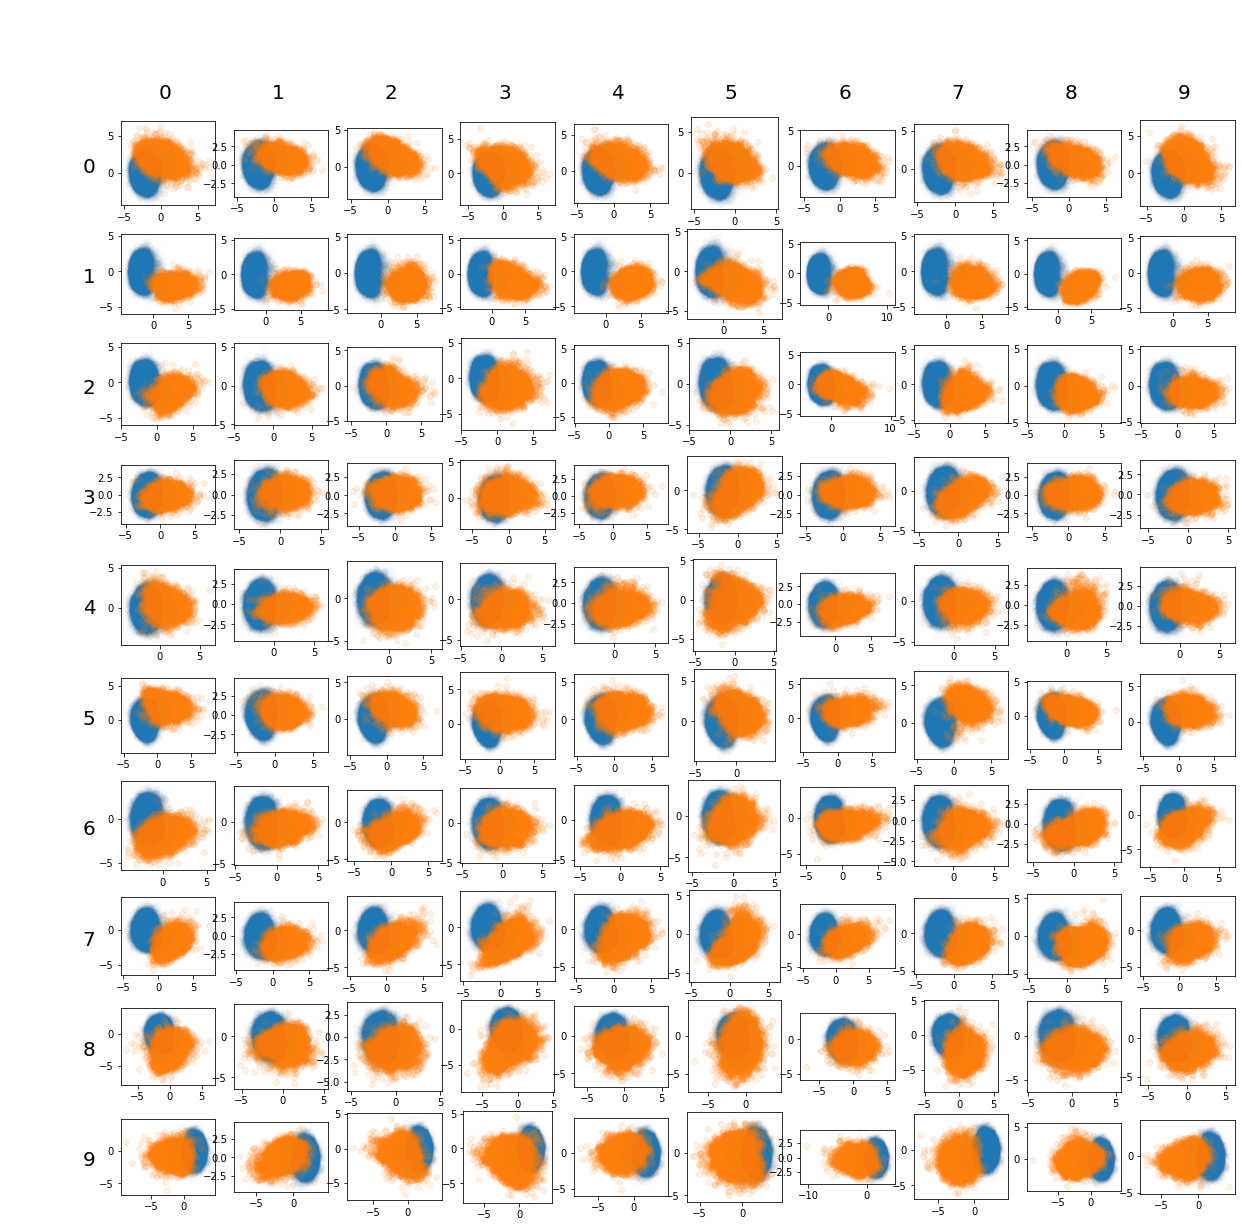

In [4]:
latent = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
classes = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
    
fig, axes = plt.subplots(11, 11, figsize=(22, 22))

for i in range(10):

    _, _, v = torch.svd(latent[classes == i])
    latent_pca = (latent[classes == i]) @ v[:, :2]
    latent_km = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_{i}.pt")
    classes_km = torch.load(f"runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_{i}.pt")
    latent_km_pca = latent_km @ v[:, :2]
    
    for j in range(10):

        ax = axes[i+1, j+1]

        ax.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.01)
        ax.scatter(latent_km_pca[classes_km == j][:, 0], latent_km_pca[:, 1][classes_km == j], alpha=0.1)

        ax.set_aspect('equal')

axes[0, 0].set_axis_off()

for i in range(10):
    axes[0, i+1].annotate(f"{i}", (0.4, 0), fontsize=20)
    axes[0, i+1].set_axis_off()
    
for i in range(10):
    axes[i+1, 0].annotate(f"{i}", (0.8, 0.4), fontsize=20)
    axes[i+1, 0].set_axis_off()

fig.show()

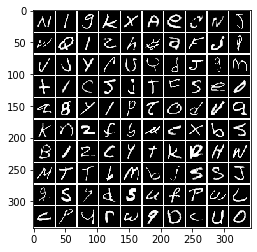

tensor([14, 12,  7, 11, 24,  1,  5,  3, 14, 10, 23, 17,  9, 26,  8,  7,  1,  6,
        10, 16, 22, 10, 25,  3, 21, 25,  4, 10,  7, 13, 20, 12,  3, 10, 10, 20,
         6, 19,  5, 15,  7,  7, 25, 12, 16, 20, 15,  4, 22, 17, 11, 14, 26,  6,
         2, 21,  3, 24,  2, 19,  2,  9, 26,  3, 25, 20, 11, 18,  8, 23, 13, 20,
        20,  2, 13,  2, 10, 19, 19, 10,  7, 19, 25,  4, 19, 21,  6, 16, 23, 12,
         3, 16, 25, 18, 23, 17,  4,  3, 21, 15])


In [50]:
def tensor2imgs(t, nrow=10):
    imgrid = torchvision.utils.make_grid(t, nrow, pad_value=1)
    return imgrid.data.mul(255).clamp(0, 255).byte().cpu().numpy()


x, y = next(iter(letter_loader))

plt.imshow(tensor2imgs(x[:100]).transpose(1, 2, 0))
plt.show()

print(y[:100])

In [ ]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_0.pt")[:10000]
classes = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_0.pt")[:10000]

latent = latent[np.logical_or(classes == 1, classes == 15)]
classes = classes[np.logical_or(classes == 1, classes == 15)]

print(latent.shape)
latent_embedded = cuml.TSNE(verbose=6, learning_rate=10, perplexity=50, n_iter=2000, n_iter_without_progress=1000, early_exaggeration=20).fit_transform(latent.numpy())

In [ ]:
fig, ax = plt.subplots()
mp = ax.scatter(latent_embedded[:, 0], latent_embedded[:, 1], alpha=0.4,
           c=classes, cmap='tab20', vmin=1, vmax=26)
ax.set_aspect('equal')
fig.colorbar(mp)
fig.show()

In [14]:
print(latent_embedded.shape)

(10000, 2)


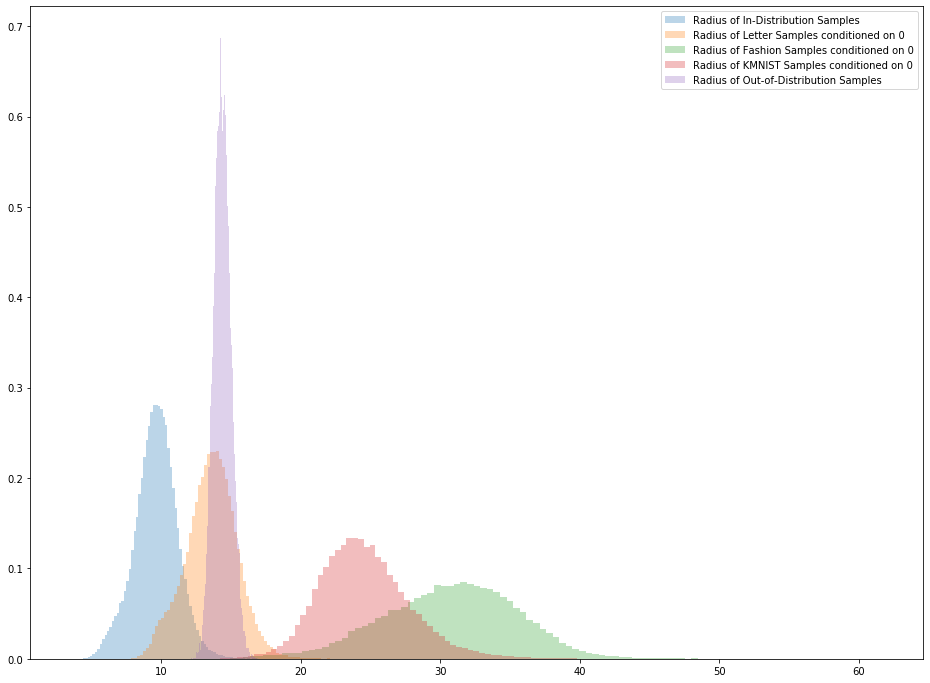

In [18]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
latent_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_0.pt")
latent_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_0.pt")
latent_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_0.pt")

plt.figure(figsize=(16, 12))
plt.hist(torch.norm(latent, dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of In-Distribution Samples')
plt.hist(torch.norm(latent_lt, dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of Letter Samples conditioned on 0')
plt.hist(torch.norm(latent_fs, dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of Fashion Samples conditioned on 0')
plt.hist(torch.norm(latent_km, dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of KMNIST Samples conditioned on 0')
plt.hist(torch.norm(zs, dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of Out-of-Distribution Samples')
plt.legend()
plt.show()

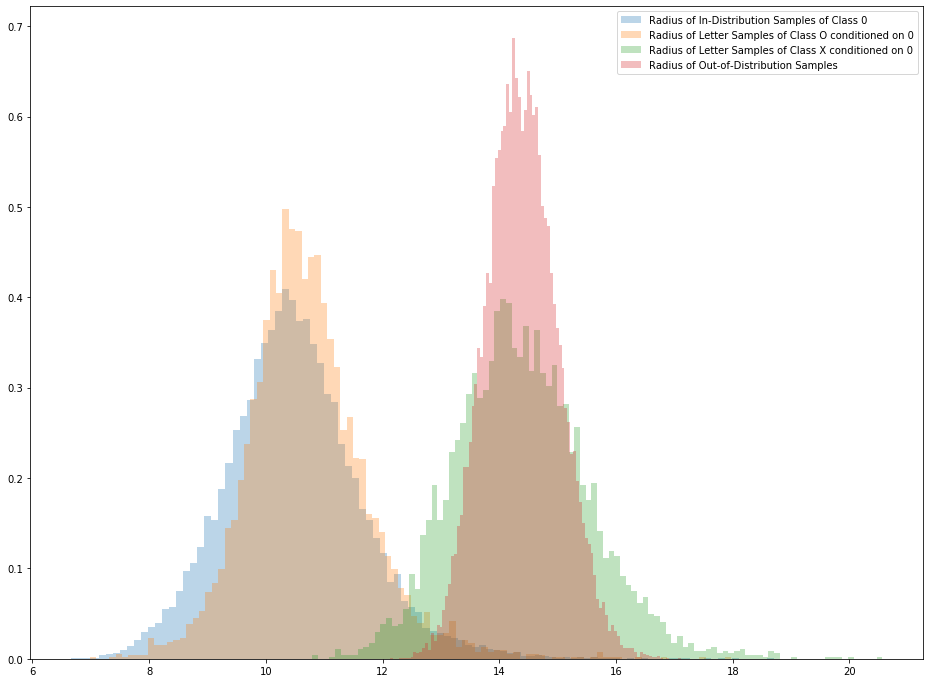

In [20]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
latent_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_0.pt")
latent_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_0.pt")
latent_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_0.pt")
classes = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
classes_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_0.pt")
classes_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_0.pt")
classes_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_0.pt")

plt.figure(figsize=(16, 12))
plt.hist(torch.norm(latent[classes == 0], dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of In-Distribution Samples of Class 0')
plt.hist(torch.norm(latent_lt[classes_lt == 15], dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of Letter Samples of Class O conditioned on 0')
plt.hist(torch.norm(latent_lt[classes_lt == 24], dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of Letter Samples of Class X conditioned on 0')
# plt.hist(torch.norm(latent_fs, dim=1), bins=100, density=True,
#                      alpha=0.2)
# plt.hist(torch.norm(latent_km, dim=1), bins=100, density=True,
#                      alpha=0.2)
plt.hist(torch.norm(zs, dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of Out-of-Distribution Samples')
plt.legend()
plt.show()

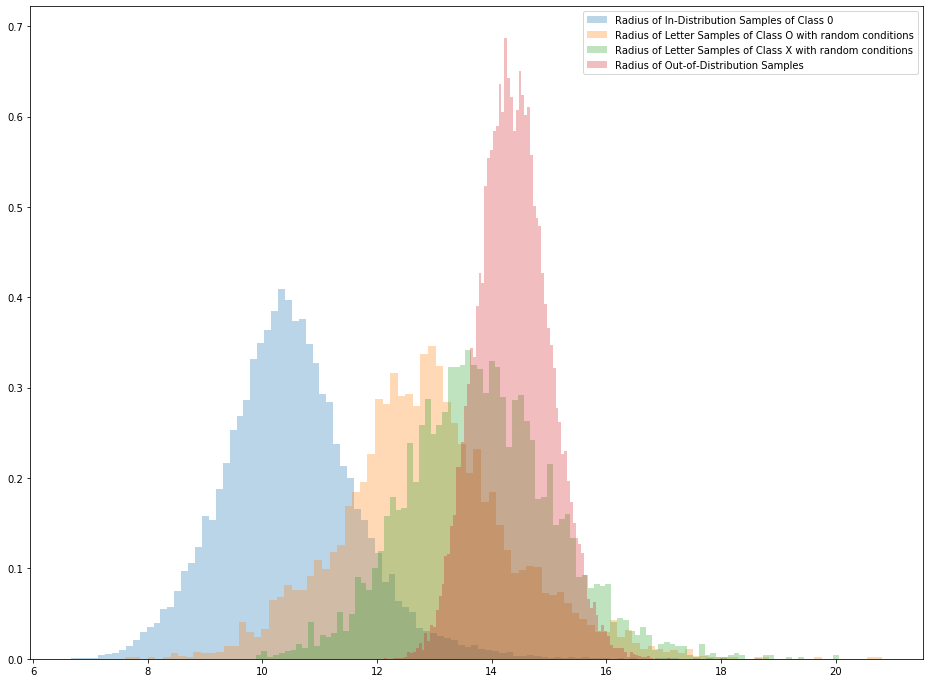

In [21]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
latent_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_rand.pt")
latent_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_0.pt")
latent_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_0.pt")
classes = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
classes_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_rand.pt")
classes_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_0.pt")
classes_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_0.pt")

plt.figure(figsize=(16, 12))
plt.hist(torch.norm(latent[classes == 0], dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of In-Distribution Samples of Class 0')
plt.hist(torch.norm(latent_lt[classes_lt == 15], dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of Letter Samples of Class O with random conditions')
plt.hist(torch.norm(latent_lt[classes_lt == 24], dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of Letter Samples of Class X with random conditions')
# plt.hist(torch.norm(latent_fs, dim=1), bins=100, density=True,
#                      alpha=0.2)
# plt.hist(torch.norm(latent_km, dim=1), bins=100, density=True,
#                      alpha=0.2)
plt.hist(torch.norm(zs, dim=1), bins=100, density=True,
                     alpha=0.3, label='Radius of Out-of-Distribution Samples')
plt.legend()
plt.show()

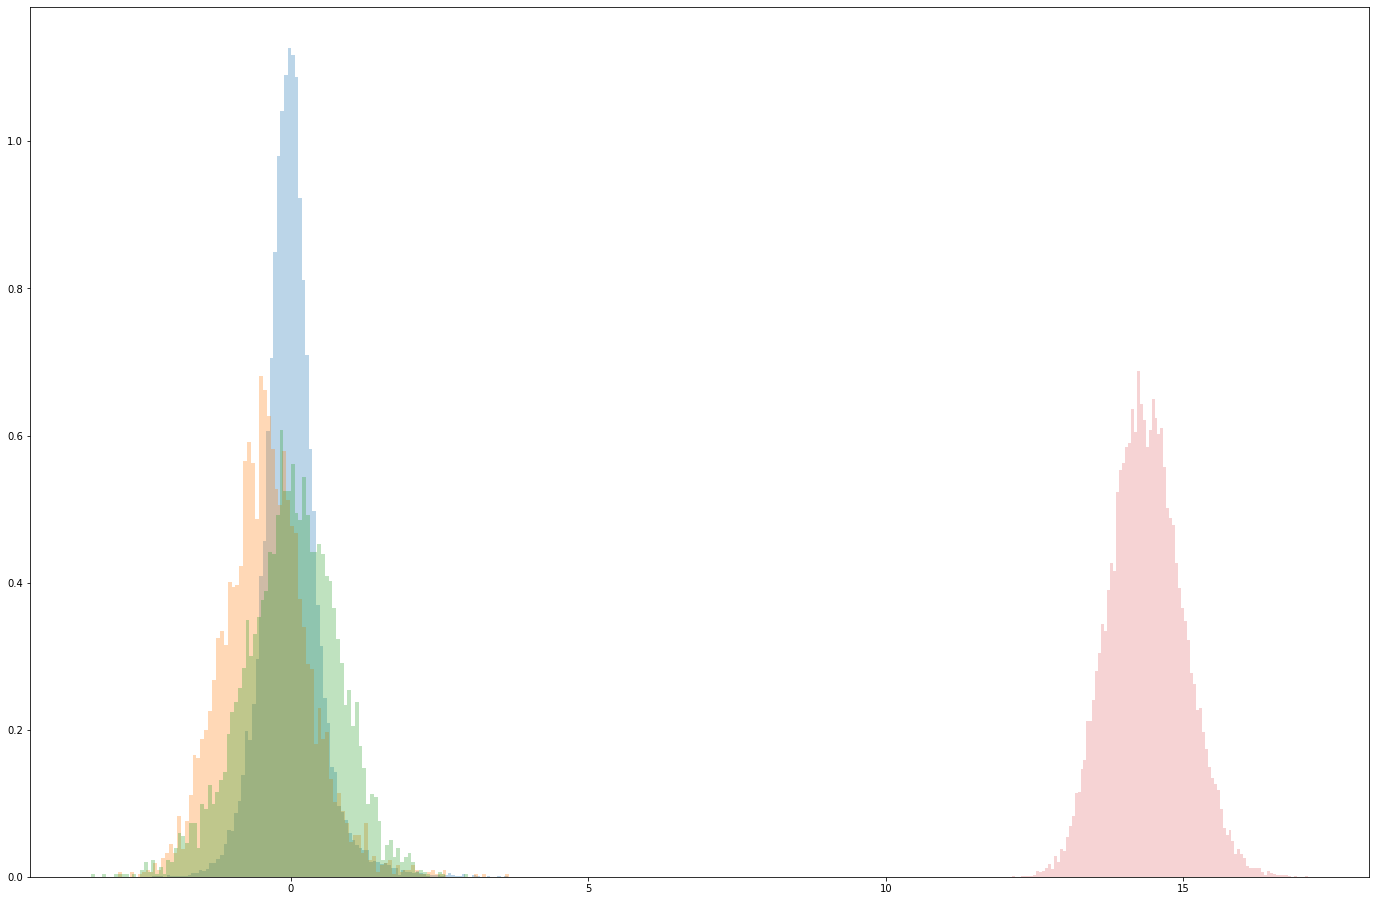

In [12]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
latent_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_rand.pt")
latent_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_0.pt")
latent_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_0.pt")
classes = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
classes_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_rand.pt")
classes_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_0.pt")
classes_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_0.pt")

d = 20
plt.figure(figsize=(24, 16))
plt.hist(latent[classes == 0][:, d], bins=100, density=True,
                     alpha=0.3)
plt.hist(latent_lt[classes_lt == 15][:, d], bins=100, density=True,
                     alpha=0.3)
plt.hist(latent_lt[classes_lt == 24][:, d], bins=100, density=True,
                     alpha=0.3)
# plt.hist(torch.norm(latent_fs, dim=1), bins=100, density=True,
#                      alpha=0.2)
# plt.hist(torch.norm(latent_km, dim=1), bins=100, density=True,
#                      alpha=0.2)
plt.hist(torch.norm(zs, dim=1), bins=100, density=True,
                     alpha=0.2)
plt.show()

RangeIndex(start=0, stop=65, step=1)


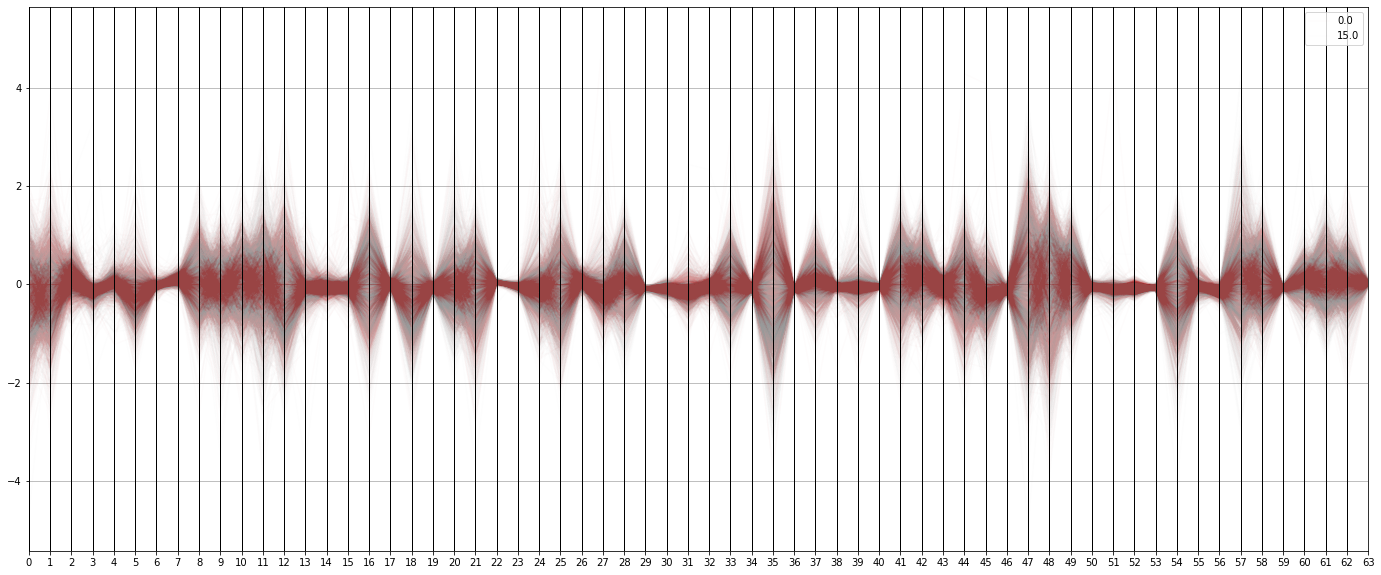

In [67]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
latent_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_0.pt")
latent_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_0.pt")
latent_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_0.pt")
classes = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
classes_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_0.pt")
classes_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_0.pt")
classes_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_0.pt")

n_coords = 64
n_samples = 2000

ind = pd.DataFrame(
    torch.cat([
        torch.cat([latent[classes==0][:n_samples, :n_coords], classes[classes==0][:n_samples].float().reshape(n_samples, 1)], dim=1),
        torch.cat([latent_lt[classes_lt==15][:n_samples, :n_coords], classes_lt[classes_lt==15][:n_samples].float().reshape(n_samples, 1)], dim=1),
#         torch.cat([latent_lt[classes_lt==24][:n_samples, :n_coords], classes_lt[classes_lt==24][:n_samples].float().reshape(n_samples, 1)], dim=1),
    ], dim=0).numpy())
print(ind.columns)

plt.figure(figsize=(24,10))
pd.plotting.parallel_coordinates(ind, n_coords, alpha=0.01, colormap="Set1")

plt.show()

RangeIndex(start=0, stop=65, step=1)


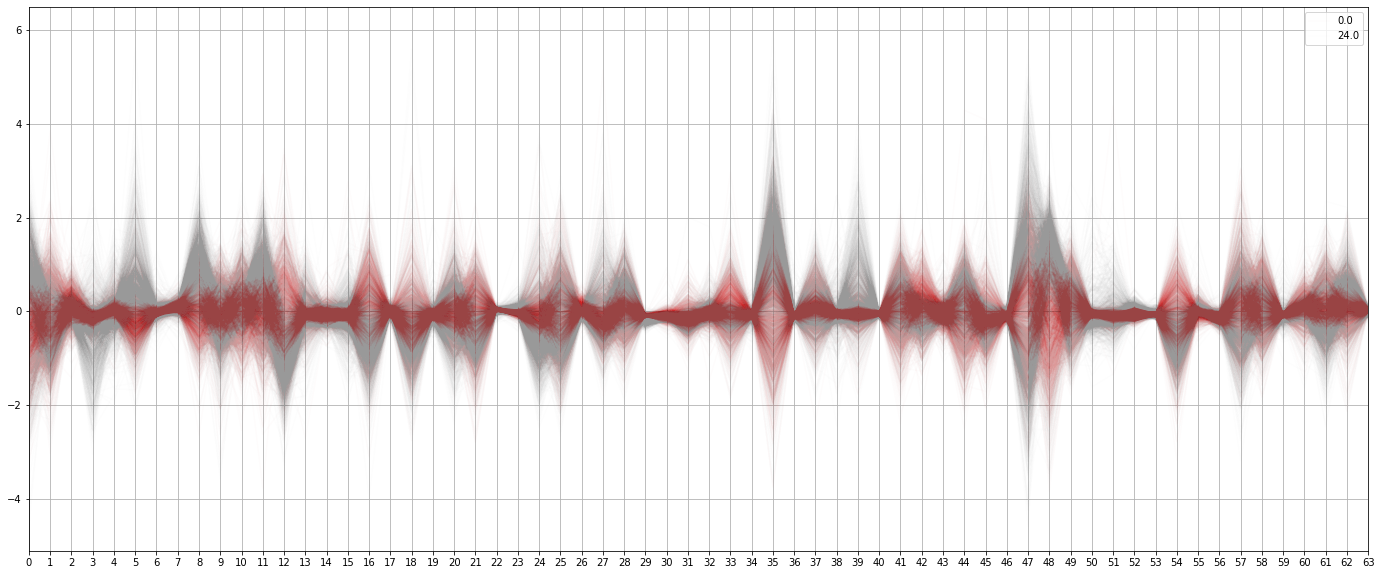

In [68]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
latent_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_0.pt")
latent_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_0.pt")
latent_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_0.pt")
classes = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
classes_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_0.pt")
classes_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_0.pt")
classes_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_0.pt")

n_coords = 64
n_samples = 2000

ind = pd.DataFrame(
    torch.cat([
        torch.cat([latent[classes==0][:n_samples, :n_coords], classes[classes==0][:n_samples].float().reshape(n_samples, 1)], dim=1),
#         torch.cat([latent_lt[classes_lt==15][:n_samples, :n_coords], classes_lt[classes_lt==15][:n_samples].float().reshape(n_samples, 1)], dim=1),
        torch.cat([latent_lt[classes_lt==24][:n_samples, :n_coords], classes_lt[classes_lt==24][:n_samples].float().reshape(n_samples, 1)], dim=1),
    ], dim=0).numpy())
print(ind.columns)

plt.figure(figsize=(24,10))
pd.plotting.parallel_coordinates(ind, n_coords, alpha=0.01, colormap="Set1", axvlines=False)
plt.show()

RangeIndex(start=0, stop=65, step=1)


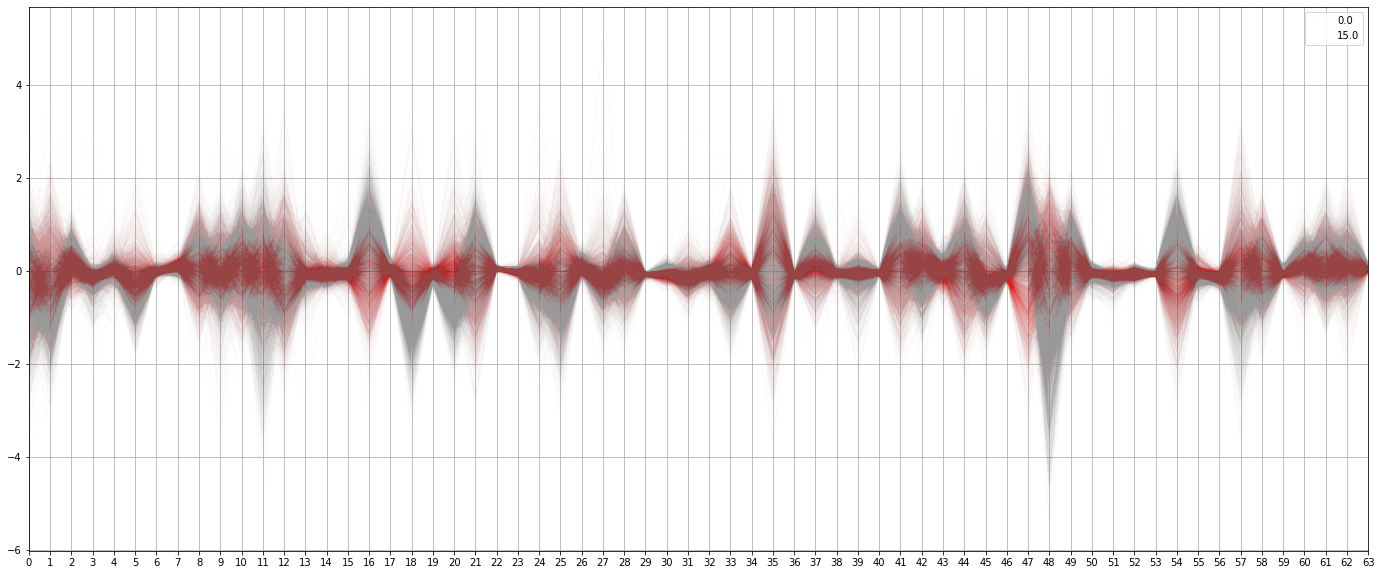

In [69]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
latent_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_1.pt")
latent_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_0.pt")
latent_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_0.pt")
classes = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
classes_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_1.pt")
classes_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_0.pt")
classes_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_0.pt")

n_coords = 64
n_samples = 2000

ind = pd.DataFrame(
    torch.cat([
        torch.cat([latent[classes==0][:n_samples, :n_coords], classes[classes==0][:n_samples].float().reshape(n_samples, 1)], dim=1),
        torch.cat([latent_lt[classes_lt==15][:n_samples, :n_coords], classes_lt[classes_lt==15][:n_samples].float().reshape(n_samples, 1)], dim=1),
#         torch.cat([latent_lt[classes_lt==24][:n_samples, :n_coords], classes_lt[classes_lt==24][:n_samples].float().reshape(n_samples, 1)], dim=1),
    ], dim=0).numpy())
print(ind.columns)

plt.figure(figsize=(24,10))
pd.plotting.parallel_coordinates(ind, n_coords, alpha=0.01, colormap="Set1", axvlines=False)
plt.show()

RangeIndex(start=0, stop=65, step=1)


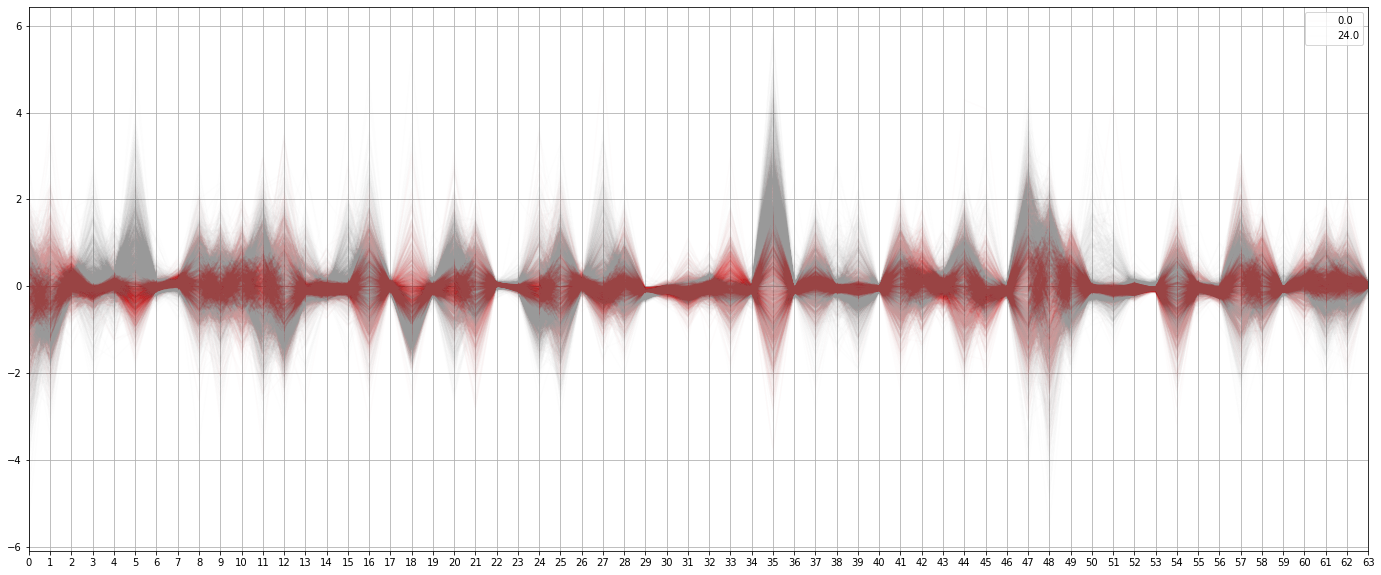

In [70]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
latent_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_1.pt")
latent_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_0.pt")
latent_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_0.pt")
classes = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
classes_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_1.pt")
classes_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_0.pt")
classes_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_0.pt")

n_coords = 64
n_samples = 2000

ind = pd.DataFrame(
    torch.cat([
        torch.cat([latent[classes==0][:n_samples, :n_coords], classes[classes==0][:n_samples].float().reshape(n_samples, 1)], dim=1),
#         torch.cat([latent_lt[classes_lt==15][:n_samples, :n_coords], classes_lt[classes_lt==15][:n_samples].float().reshape(n_samples, 1)], dim=1),
        torch.cat([latent_lt[classes_lt==24][:n_samples, :n_coords], classes_lt[classes_lt==24][:n_samples].float().reshape(n_samples, 1)], dim=1),
    ], dim=0).numpy())
print(ind.columns)

plt.figure(figsize=(24,10))
pd.plotting.parallel_coordinates(ind, n_coords, alpha=0.01, colormap="Set1", axvlines=False)
plt.show()

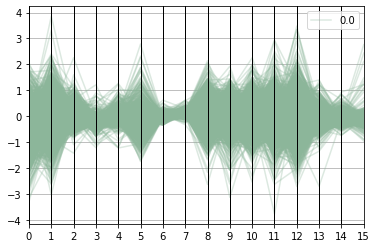

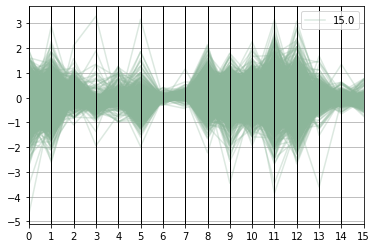

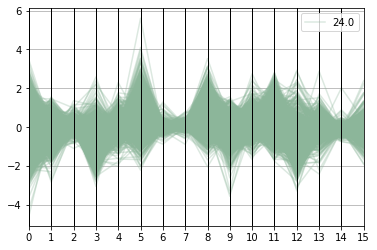

In [45]:
latent = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent.pt")
latent_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_lt_1.pt")
latent_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_fs_0.pt")
latent_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/latent_km_0.pt")
classes = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes.pt")
classes_lt = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_lt_1.pt")
classes_fs = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_fs_0.pt")
classes_km = torch.load("runs/May13_19-39-26_GLaDOS/checkpoints/classes_km_0.pt")

n_coords = 16
n_samples = 2000

ind = pd.DataFrame(torch.cat([latent[classes==0][:n_samples, :n_coords], classes[classes==0][:n_samples].float().reshape(n_samples, 1)], dim=1).numpy())
pd.plotting.parallel_coordinates(ind, n_coords, alpha=0.3)
plt.show()

ind = pd.DataFrame(torch.cat([latent_lt[classes_lt==15][:n_samples, :n_coords], classes_lt[classes_lt==15][:n_samples].float().reshape(n_samples, 1)], dim=1).numpy())
pd.plotting.parallel_coordinates(ind, n_coords, alpha=0.3)
plt.show()

ind = pd.DataFrame(torch.cat([latent_lt[classes_lt==24][:n_samples, :n_coords], classes_lt[classes_lt==24][:n_samples].float().reshape(n_samples, 1)], dim=1).numpy())
pd.plotting.parallel_coordinates(ind, n_coords, alpha=0.3)
plt.show()